In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import cv2
from math import isclose
import importlib 
import seaborn as sns

import sys
sys.path.append("C:/Users/Leon/Documents/AI_project/AI_project")
from Image_processing.Preprocessing.utils import preprocessing as prep

***Show the Image***

***height (rows), width(cols)***

Load images from storage and pass them through the preprocessing pipeline. The individual steps are:<br>
- Read Image as BGR Format<br>
- Resize Image to square format<br>
- Draw bounding box around the object in the image and convert it to RGB<br>
- get Hight and Width from the bounding box<br>
- check If the box is rotated and depending on that crop the area of the bounding box out of the image<br>
- Do Object Segmentation on the cropped image and return the binary segmented img (mask)<br>
- Get the segmented cropped RGB image<br>
- Place a green mask on the segmented cropped RGB image and get only the green pixels<br>
- Calculate the color from the segmented cropped RGB image with kmeans algorithm. Set k=2<br>
- Write the desired features to the dataframe

In [12]:
folders = ["Zwiebel", "Karotte", "Kartoffel", "Karotte_Trieb", "Zwiebel_Trieb", "Kartoffel_Trieb"]
#folders = ["Internet"]
paths = []
for fold in folders:
    for i, fname in enumerate(os.listdir(f"G:/Meine Ablage/KI_Projekt/Trainingsdaten/{fold}"), 1):
        paths.append(f"G:/Meine Ablage/KI_Projekt/Trainingsdaten/{fold}/{fname}")
        #if i == 25:
        #    break
print(len(paths))
print(paths[10:15])

2162
['G:/Meine Ablage/KI_Projekt/Trainingsdaten/Zwiebel/zwiebel_11.jpg', 'G:/Meine Ablage/KI_Projekt/Trainingsdaten/Zwiebel/zwiebel_12.jpg', 'G:/Meine Ablage/KI_Projekt/Trainingsdaten/Zwiebel/zwiebel_13.jpg', 'G:/Meine Ablage/KI_Projekt/Trainingsdaten/Zwiebel/zwiebel_14.jpg', 'G:/Meine Ablage/KI_Projekt/Trainingsdaten/Zwiebel/zwiebel_15.jpg']


In [10]:
demo_img = ['G:/Meine Ablage/KI_Projekt/Bilder/Kartoffel_Trieb/kartoffel_trieb_65.jpg'] #karotte_trieb_17
# 209 previous karotte_trieb Trainingsdaten
paths = demo_img

In [4]:
importlib.reload(prep)

<module 'Image_processing.Preprocessing.utils.preprocessing' from 'C:\\Users/Leon/Documents/AI_project/AI_project\\Image_processing\\Preprocessing\\utils\\preprocessing.py'>

In [13]:
columns=["Hight", "Width", "R", "G", "B", "green pixels",
        "green onion pixels", "ratio area", "circularity", 
        "keypoints", "mean keypoints", "sym_vertical", "sym_horizontal", "Label", "Image"]
data = []
error_counter = 0
for i, path in enumerate(paths):
    if 'desktop.ini' in path:
        continue

    ############################# Label the image ##################################
    vegi_label = path.split("/")[4]
    
    vegi_BGR = cv2.imread(path) # As BGR
    vegi_sq_BGR_original = prep.resize_to_square(vegi_BGR) # BGR

    try:
        ############################# Find Contours in image and draw a bounding box ##################################
        contour_vegi = prep.get_obj_contour(vegi_sq_BGR_original)

        # get and draw the bounding box
        rect = cv2.minAreaRect(contour_vegi)
        box = np.intp(cv2.boxPoints(rect))
        # draw bounding box
        vegi_with_box_rgb = cv2.drawContours(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB), 
                                            [box], 
                                            0, 
                                            (0, 255, 0), 2)

        ############################# Calculate the Circularity Feature ##################################
        circularity = prep.get_circularity(contour_vegi)

        ############################# Get pixel size from the bounding box (hight and width) ##################################
        h, w = [int(l) for l in prep.get_size_box(box)]
        
        ############################# Calculate the Ratio Area Feature alias compactness ##################################
        ratio_area_box = 0
        area = cv2.contourArea(contour_vegi)
        if h > 0 and w > 0:
            ratio_area_box = area / (h * w)

        ############################# Crop the including area from the bounding box (our ROI) ##################################
        if not prep.is_box_rotated(box):
            #crop img directly
            # the top left corner should be the first element in box array
            cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w] 
        else:
            cropped_vegi_BGR = prep.crop_roi(vegi_sq_BGR_original, box) # BGR

        ############################# Do a binary segmentation only with the roi  ##################################
        #cropped_segmented_binary_2 = prep.segment_img_2(cropped_vegi_BGR)
        #print("Segmented BINARY original")
        #prep.show_image_plt(cropped_segmented_binary_2, cmap="gray")

        ####################### TEST new segmentation #################################
        cropped_segmented_binary_3 = prep.segment_img_3(cropped_vegi_BGR)
        #print("Segmented BINARY From new Segmentation Method")
        #prep.show_image_plt(cropped_segmented_binary_3, cmap="gray")

        
        ############################# Apply the binary mask on the cropped image  ##################################
        cropped_vegi_segmented_rgb_3 = prep.color_from_segmented_binary(cropped_segmented_binary_3, cropped_vegi_BGR) # center has rgb format
        #print("Segmented RGB")
        #show_image_plt(cropped_vegi_segmented_rgb_2)

        ##################### SIFT Algorithm - Calculates the mean keypoints and number of keypoints features #######################################
        num_kps, mean_kps = prep.sift(vegi_sq_BGR_original)

        ############################# Apply a green mask on the image ##################################
        # Seems to be work best
        vegi_only_onion_tribe_rgb, onion_tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_3, lower_thresh=(25, 40, 20), higher_thresh=(60, 160, 255))
        #print("ONLY GREEn TRIBE MASK")
        #show_image_plt(vegi_only_onion_tribe_rgb)
        vegi_only_tribe_rgb, tribe_mask = prep.mask_green(cropped_vegi_segmented_rgb_3, lower_thresh=(27, 105, 20), higher_thresh=(120, 255, 255))

        ############################# Calculates the number of green pixels feature  ##################################
        amount_green_pixels_onion_tribe = prep.count_green_pixels(onion_tribe_mask)
        amount_green_pixels_tribe = prep.count_green_pixels(tribe_mask)

        ############################# Get the Color (R, G, B) Feature(s) with a kmean algorithm ##################################
        center = prep.get_color(cropped_vegi_segmented_rgb_3) #Center = RGB
        #print("center: ", center)
        R, G, B = np.max(center, axis=0)
        
        # check if any points are outside of the image if yes move them within the img boundaries
        resized_box = prep.recalculate_bounding_box(box)
        rotated_points = prep.rotate_edge_points(resized_box, rect[2])
        #print("rotated points")
        aligned_points = prep.align_edge_points(rotated_points)
        aligned_points = np.array([(prep.clip_aligned_points(x), prep.clip_aligned_points(y)) for x,y in aligned_points])

        # rotate img and draw new bounding box
        # RGB format
        rotated_img = prep.rotate_img(vegi_with_box_rgb, rect[2])
        #vegi_with_new_box_rgb = prep.draw_rotated_box(rotated_img, aligned_points)

        sym_v = prep.calc_symmetry(rotated_img, aligned_points, "vertical")
        sym_h = prep.calc_symmetry(rotated_img, aligned_points, "horizontal")
        
        #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/Debugging_resize_function_v3/{img_name}_{i}.jpg", cv2.cvtColor(vegi_with_new_box_rgb, cv2.COLOR_BGR2RGB))
        #cv2.imwrite(f"G:/Meine Ablage/KI_Projekt/Bilder/originally_box/{img_name}_{i}.jpg", cv2.cvtColor(vegi_with_box_rgb, cv2.COLOR_BGR2RGB))
       
        img_nr = path.split(".")[0].split("_")[-1]
        img_name = f"{vegi_label}_{img_nr}"
        
        features = [h, w, R, G, B, amount_green_pixels_tribe, amount_green_pixels_onion_tribe, ratio_area_box, circularity, num_kps, mean_kps, sym_v, sym_h, vegi_label, img_name]
        data.append(features)
        
        if i < 3:
            print(data)

        #if i == 6:
        #    break
        
    except Exception as e:
        print("Error: ", e)
        error_counter += 1
        continue

vegis_df = pd.DataFrame(data, columns=columns)
display(vegis_df.head(20))
print("Shape: ", vegis_df.shape)

[[125, 70, 117, 72, 53, 0, 0, 0.6476, 0.4970617910232986, 29, 7.9315669783230485, 0.8, 0.74, 'Zwiebel', 'Zwiebel_1']]
[[125, 70, 117, 72, 53, 0, 0, 0.6476, 0.4970617910232986, 29, 7.9315669783230485, 0.8, 0.74, 'Zwiebel', 'Zwiebel_1'], [100, 97, 93, 63, 61, 0, 29, 0.6589690721649485, 0.4481484519368207, 29, 12.216909762086539, 0.9, 1.0, 'Zwiebel', 'Zwiebel_2']]
[[125, 70, 117, 72, 53, 0, 0, 0.6476, 0.4970617910232986, 29, 7.9315669783230485, 0.8, 0.74, 'Zwiebel', 'Zwiebel_1'], [100, 97, 93, 63, 61, 0, 29, 0.6589690721649485, 0.4481484519368207, 29, 12.216909762086539, 0.9, 1.0, 'Zwiebel', 'Zwiebel_2'], [108, 103, 131, 89, 62, 0, 3, 0.7802948579647608, 0.8261319728569928, 38, 16.189531762348977, 0.86, 0.88, 'Zwiebel', 'Zwiebel_3']]
Error:  'NoneType' object has no attribute 'flatten'


,Hight,Width,R,G,B,green pixels,green onion pixels,ratio area,circularity,keypoints,mean keypoints,sym_vertical,sym_horizontal,Label,Image
0,125,70,117,72,53,0,0,0.647600,0.497062,29,7.931567,0.80,0.74,Zwiebel,Zwiebel_1
1,100,97,93,63,61,0,29,0.658969,0.448148,29,12.216910,0.90,1.00,Zwiebel,Zwiebel_2
2,108,103,131,89,62,0,3,0.780295,0.826132,38,16.189532,0.86,0.88,Zwiebel,Zwiebel_3
3,115,104,126,88,64,0,51,0.615217,0.330286,22,16.265382,0.79,0.78,Zwiebel,Zwiebel_4
4,141,101,141,119,98,0,223,0.362615,0.112285,25,9.326496,0.45,0.43,Zwiebel,Zwiebel_5
5,127,111,128,91,61,0,0,0.745974,0.740179,71,7.509945,0.79,0.87,Zwiebel,Zwiebel_6
6,126,124,127,93,66,0,0,0.744176,0.697617,52,7.147105,0.59,0.79,Zwiebel,Zwiebel_7
7,127,116,118,82,55,0,0,0.733879,0.720333,43,8.524930,0.88,0.87,Zwiebel,Zwiebel_8
8,207,156,118,89,59,0,0,0.289731,0.144309,43,10.854530,0.54,0.06,Zwiebel,Zwiebel_9
9,196,112,118,87,57,0,5,0.365889,0.227230,29,11.519960,0.75,0.11,Zwiebel,Zwiebel_10


Shape:  (2155, 15)


In [14]:
vegis_df.tail()

,Hight,Width,R,G,B,green pixels,green onion pixels,ratio area,circularity,keypoints,mean keypoints,sym_vertical,sym_horizontal,Label,Image
2150,126,76,116,87,48,0,0,0.821168,0.720998,44,5.291746,0.94,0.89,Kartoffel_Trieb,Kartoffel_Trieb_271
2151,164,104,122,91,47,0,0,0.685595,0.602414,73,4.673951,0.77,0.85,Kartoffel_Trieb,Kartoffel_Trieb_272
2152,151,79,118,89,51,0,1,0.763811,0.623197,45,4.362924,0.88,0.91,Kartoffel_Trieb,Kartoffel_Trieb_273
2153,127,71,119,90,49,0,0,0.772374,0.667829,43,5.440125,0.85,0.87,Kartoffel_Trieb,Kartoffel_Trieb_274
2154,131,80,103,74,39,0,1,0.560878,0.327549,56,5.755652,0.59,0.18,Kartoffel_Trieb,Kartoffel_Trieb_275


In [15]:
vegis_df.to_csv("G:/Meine Ablage/KI_Projekt/Daten/vegis_traindata_280324.csv", index=False)

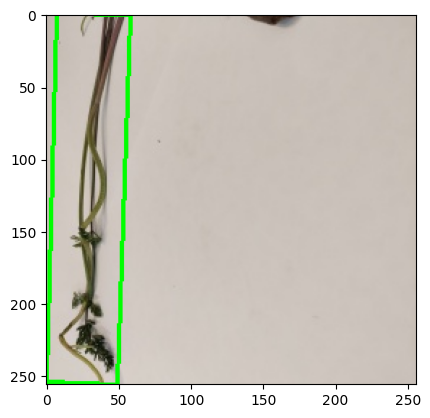

In [35]:
prep.show_image_plt(vegi_with_box_rgb)

In [34]:
rotated_points

[(4, 257), (1, 4), (52, 3), (53, 257)]

In [33]:
len(data)

3461

v_line_before:  126
h_line_before:  134
v_line:  126
h_line:  134
(126, 134)
center:  (145, 139)


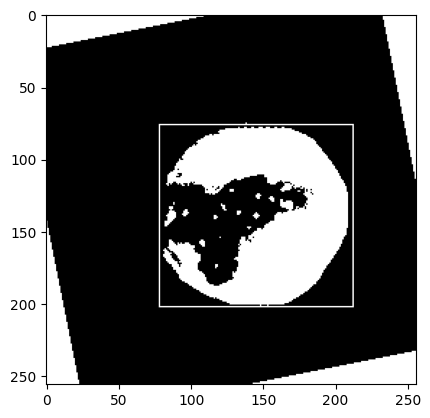

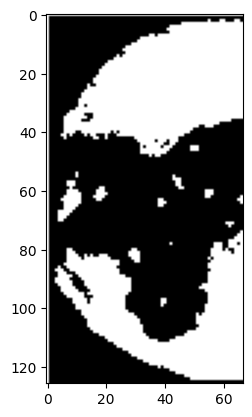

shape left_half_  (126, 67)
vertical flip


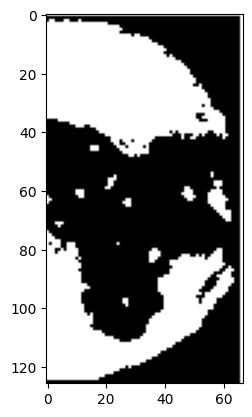

crop from rotated box


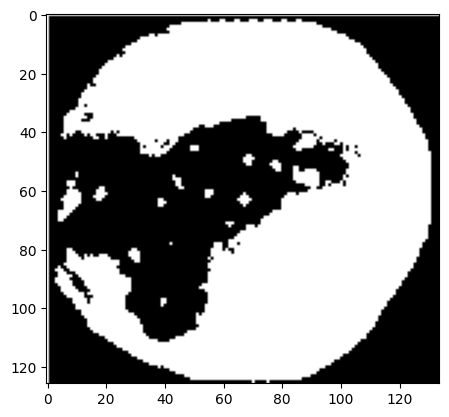

mirror left half


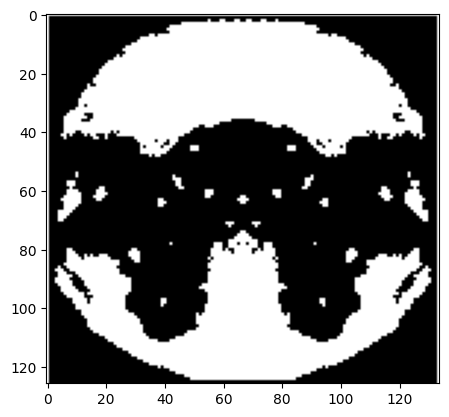

shape left_half:  (126, 67)
shape v_flip:  (126, 134)


In [7]:
vegi_box = vegi_with_new_box_rgb.copy()
#vegi_box = cv2.cvtColor(vegi_box, cv2.COLOR_RGB2GRAY)
vegi_box = prep.segment_img_2(vegi_box)
# width and weight should be a even number because later it's easier to calculate
v_line = int(np.linalg.norm(aligned_points[1] - aligned_points[0]))
h_line = int(np.linalg.norm(aligned_points[3] - aligned_points[0]))
print("v_line_before: ", v_line)
print("h_line_before: ", h_line)
aligned_points = aligned_points.copy()
# if the length of the lines are odd values then remove one pixel row and/or column
if v_line % 2 != 0:
    v_line -= 1
    aligned_points[1][1] += 1
    aligned_points[2][1] += 1
if h_line % 2 != 0:
    h_line -= 1
    aligned_points[2][0] -= 1
    aligned_points[3][0] -= 1

print("v_line: ", v_line)
print("h_line: ", h_line)

# crop new box
crop_new_box = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]:aligned_points[1][0]+h_line]
#crop_new_box = vegi_box[aligned_points[1][1]:aligned_points[0][1], aligned_points[1][0]:aligned_points[2][0]]

print(crop_new_box.shape)

# calc center point. Only needed for debugging
center = (aligned_points[1][0] + (h_line // 2)), (aligned_points[1][1] + (v_line // 2))
assert isclose(int(np.linalg.norm(aligned_points[1] - center)), int(np.linalg.norm(aligned_points[2] - center)), abs_tol=1), "Center is not in the middle of the box"
print("center: ", center)
cv2.line(vegi_box, center, center, (255, 0, 255), 4)
prep.show_image_plt(vegi_box, cmap="gray")

# crop vertical along vertical sym line
#cropped_vegi_BGR = vegi_sq_BGR_original[box[0][1]:box[0][1]+h, box[0][0]:box[0][0]+w] 
# array rows corresponds to img height
left_half = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]:aligned_points[1][0]+(h_line // 2)]
prep.show_image_plt(left_half, cmap="gray")
print("shape left_half_ ", left_half.shape)
left_half_v_flipped = cv2.flip(left_half, 1)
print("vertical flip")
prep.show_image_plt(left_half_v_flipped, cmap="gray")


# stack horizontally
v_flip = np.concatenate((left_half, left_half_v_flipped), axis=1)
print("crop from rotated box")
prep.show_image_plt(crop_new_box, cmap="gray")
print("mirror left half")
prep.show_image_plt(v_flip, cmap="gray")

print("shape left_half: ", left_half.shape)
print("shape v_flip: ", v_flip.shape)

left half flipped


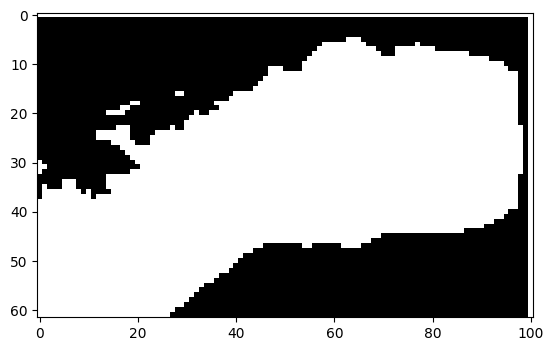

orig


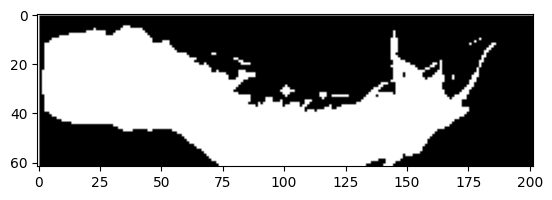

right half


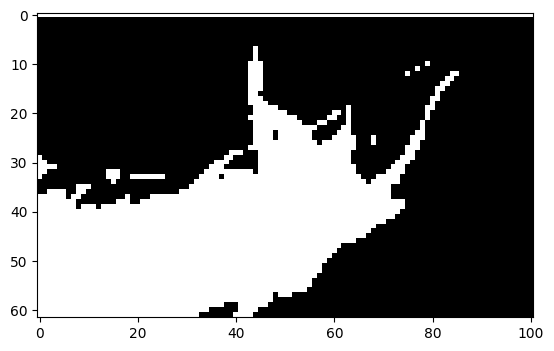

overlap_count:  1814
orig_area:  3598
sym:  0.5041689827682045


In [55]:
print("left half flipped")
plt.imshow(left_half_v_flipped, cmap="gray")
plt.show()
print("orig")
plt.imshow(crop_new_box, cmap="gray")
plt.show()
right_half = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]+(h_line // 2):aligned_points[2][0]]
print("right half")
plt.imshow(right_half, cmap="gray")
plt.show()
assert left_half.shape == right_half.shape, "Shapes are not equal"

# really slow algorithm - iterate over each pixel in flipped img and compare if the pixel exist in the original img
overlap_count = 0
for row in range(left_half_v_flipped.shape[0]):
    for col in range(left_half_v_flipped.shape[1]):
        if left_half_v_flipped[row][col] != 0 and left_half_v_flipped[row][col] == right_half[row][col]:
            overlap_count += 1
        else:
            continue

orig_area = np.unique(left_half_v_flipped, return_counts=True)[1][1]
# min = 0, max = 1
sym = overlap_count / orig_area
print("overlap_count: ", overlap_count)
print("orig_area: ", orig_area)
print("sym: ", sym)

In [85]:
right_half.shape
left_half_v_flipped.shape

(204, 92)

In [86]:
right_half.shape

(204, 93)

In [69]:
aligned_points

array([[ 53, 206],
       [ 53,   2],
       [238,   2],
       [238, 206]])

In [89]:
print(arr_flipped.shape)
print(arr_right_half.shape)

(18768,)
(18768,)


In [88]:
print(left_half_v_flipped.shape)
print(right_half.shape)

(204, 92)
(204, 92)


In [108]:
sym_ = prep.calc_symmetry(vegi_with_new_box_rgb, aligned_points, "vertical")
print(sym_)

0.5


In [106]:
right_half = vegi_box[aligned_points[1][1]:aligned_points[1][1]+v_line, aligned_points[1][0]+(h_line // 2):aligned_points[2][0]]
print()
arr_flipped = left_half_v_flipped.flatten()
arr_right_half = right_half.flatten()
assert arr_flipped.shape == arr_right_half.shape

overlap_count = np.sum((arr_flipped == 255) & (arr_right_half == 255))

orig_area = np.unique(left_half_v_flipped, return_counts=True)[1][1]
# min = 0, max = 1
sym = overlap_count / orig_area
print("overlap_count: ", overlap_count)
print("orig_area: ", orig_area)
print("sym: ", sym)


overlap_count:  1814
orig_area:  3598
sym:  0.5041689827682045


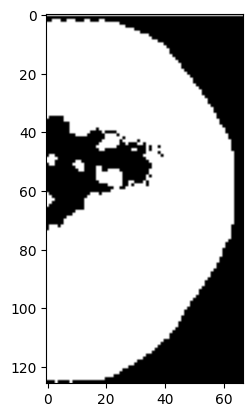

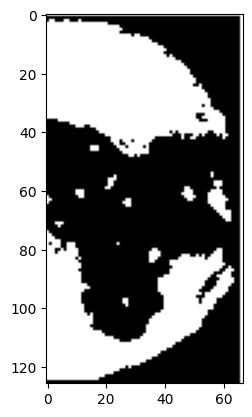

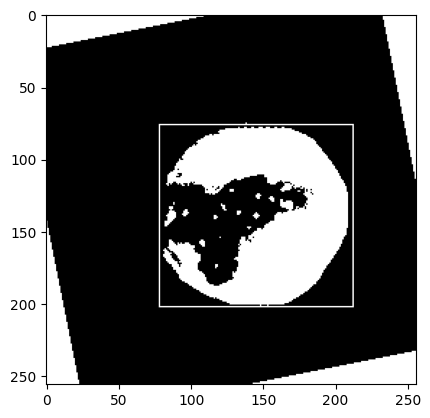

In [102]:
prep.show_image_plt(right_half, cmap="gray")
prep.show_image_plt(left_half_v_flipped, cmap="gray")
prep.show_image_plt(vegi_box, cmap="gray")


The resized image to 256x256 pixels


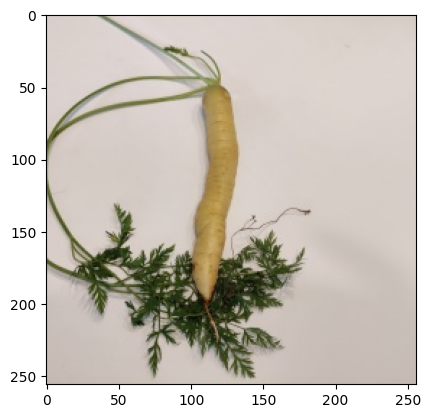

Shows the bounding box which was drawed around the founded contours


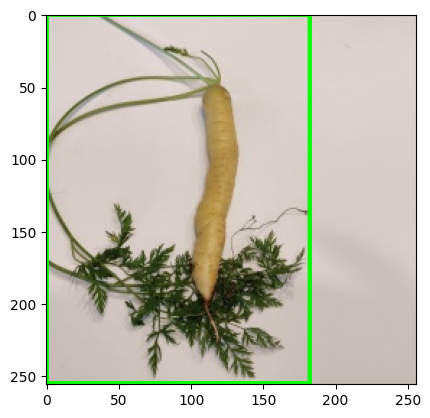

Segmented Binary Image 


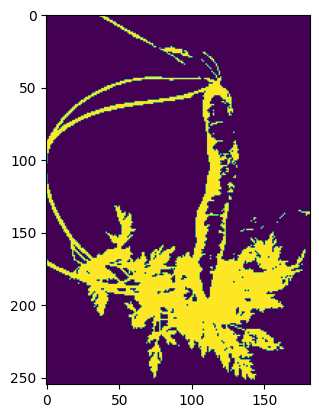

Segmented Image after applying the binary mask


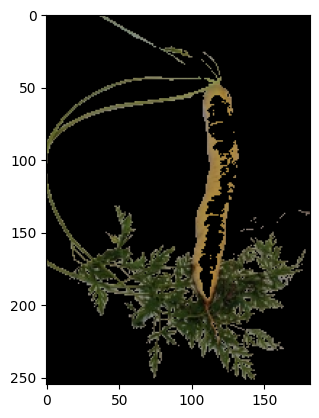

Shows the green color mask to get only the green pixels from the image


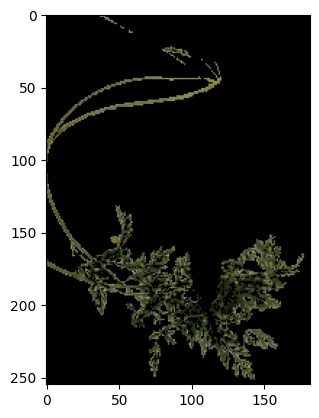

In [121]:
print("The resized image to 256x256 pixels")
prep.show_image_plt(cv2.cvtColor(vegi_sq_BGR_original, cv2.COLOR_BGR2RGB))

print("Shows the bounding box which was drawed around the founded contours")
prep.show_image_plt(vegi_with_box_rgb)

print("Segmented Binary Image ")
prep.show_image_plt(cropped_segmented_binary_2)

print("Segmented Image after applying the binary mask")
prep.show_image_plt(cropped_vegi_segmented_rgb_2)

print("Shows the green color mask to get only the green pixels from the image")
prep.show_image_plt(vegi_only_onion_tribe_rgb)

In [48]:
vegis_df_copy = vegis_df.copy()
vegis_df_copy.describe()

,Hight,Width,R,G,B,green pixels,green onion pixels,ratio area,circularity,keypoints,mean keypoints,sym_vertical,sym_horizontal
count,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000,6538.000000
mean,181.876262,104.816611,114.571123,90.589477,60.695167,1121.253747,1269.710615,0.585233,0.439200,78.783879,8.052250,0.616289,0.663801
std,68.296760,45.713900,24.600306,22.707066,21.359491,2239.571801,2267.771356,0.192788,0.273160,89.117535,6.925209,0.225374,0.236536
min,50.000000,31.000000,37.000000,25.000000,8.000000,0.000000,0.000000,0.020921,0.002807,0.000000,0.000000,0.000000,0.000000
25%,124.000000,67.000000,104.000000,78.000000,48.000000,0.000000,0.000000,0.423966,0.180625,25.000000,4.764334,0.450000,0.490000
50%,185.000000,96.000000,118.000000,90.000000,60.000000,0.000000,0.000000,0.634484,0.381521,46.000000,6.322390,0.660000,0.700000
75%,247.000000,130.000000,131.000000,105.000000,72.000000,1021.000000,1591.500000,0.764312,0.726133,85.000000,8.454842,0.800000,0.860000
max,355.000000,255.000000,182.000000,169.000000,162.000000,12628.000000,11997.000000,0.876801,0.897387,513.000000,85.071350,1.000000,1.000000


In [44]:
vegis_df_copy.columns

Index(['Hight', 'Width', 'R', 'G', 'B', 'green pixels', 'green onion pixels',
       'ratio area', 'circularity', 'keypoints', 'mean keypoints',
       'sym_vertical', 'sym_horizontal', 'Label', 'Image'],
      dtype='object')

['Zwiebel' 'Karotte' 'Kartoffel' 'Karotte_Trieb' 'Zwiebel_Trieb'
 'Kartoffel_Trieb']



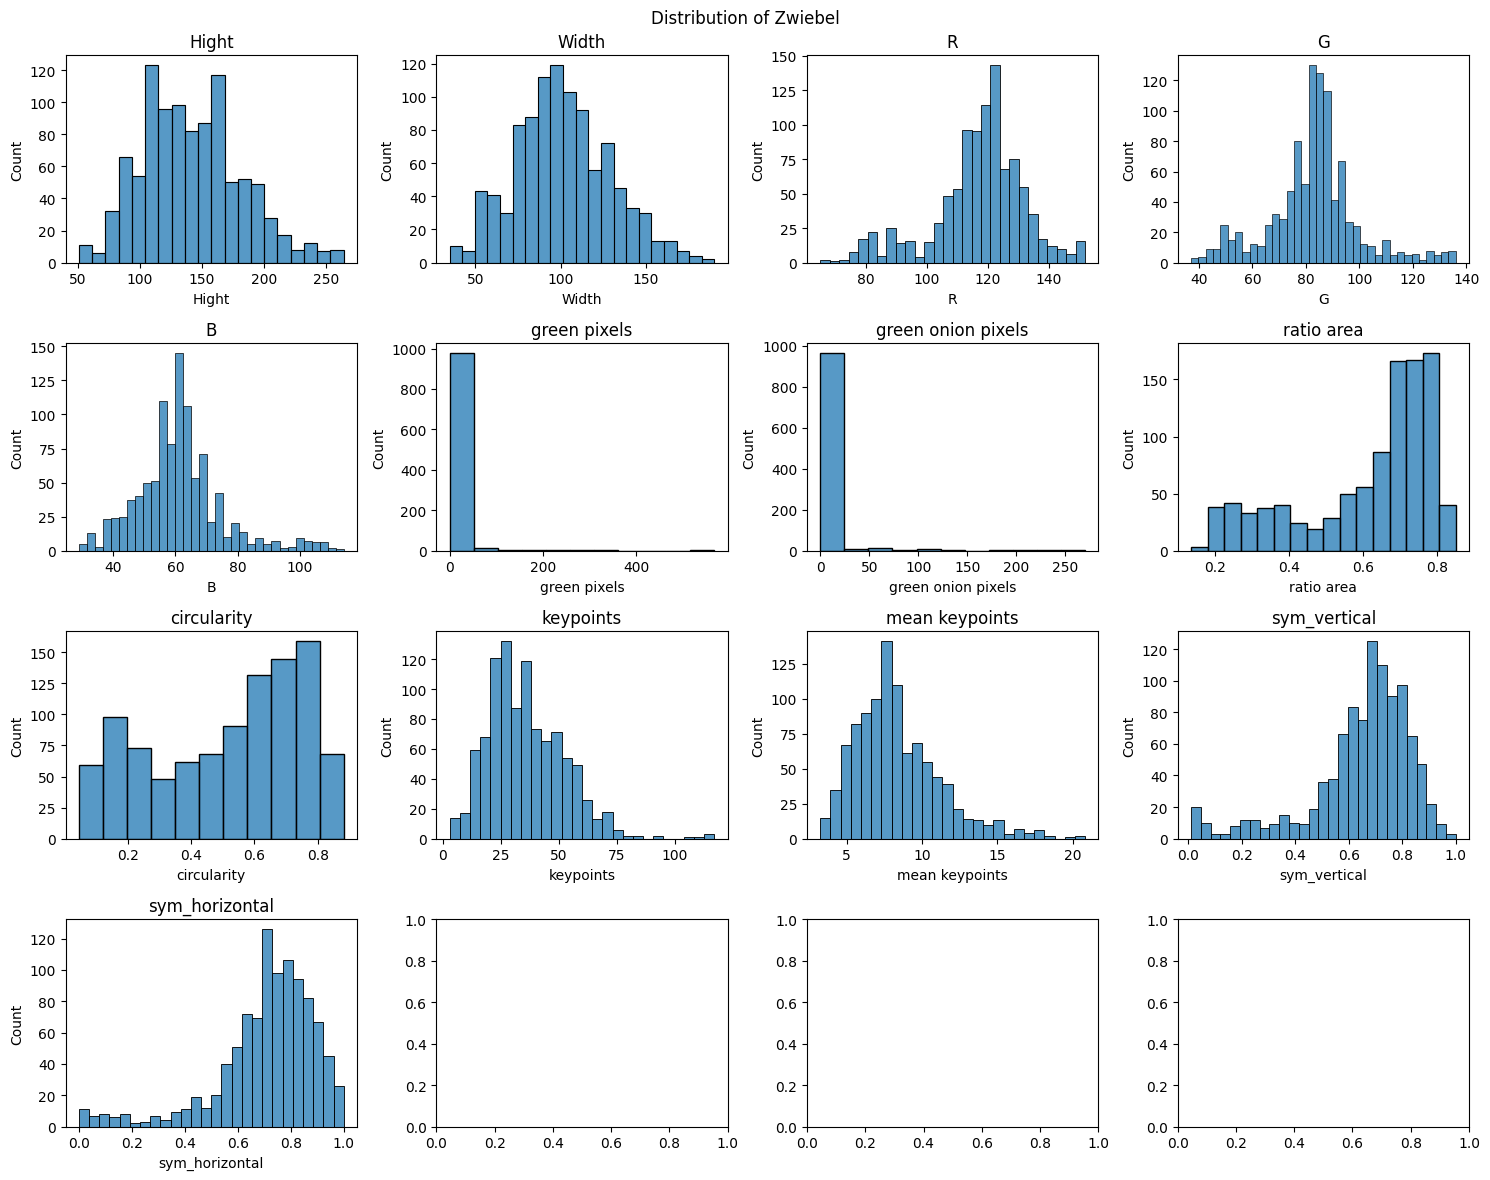

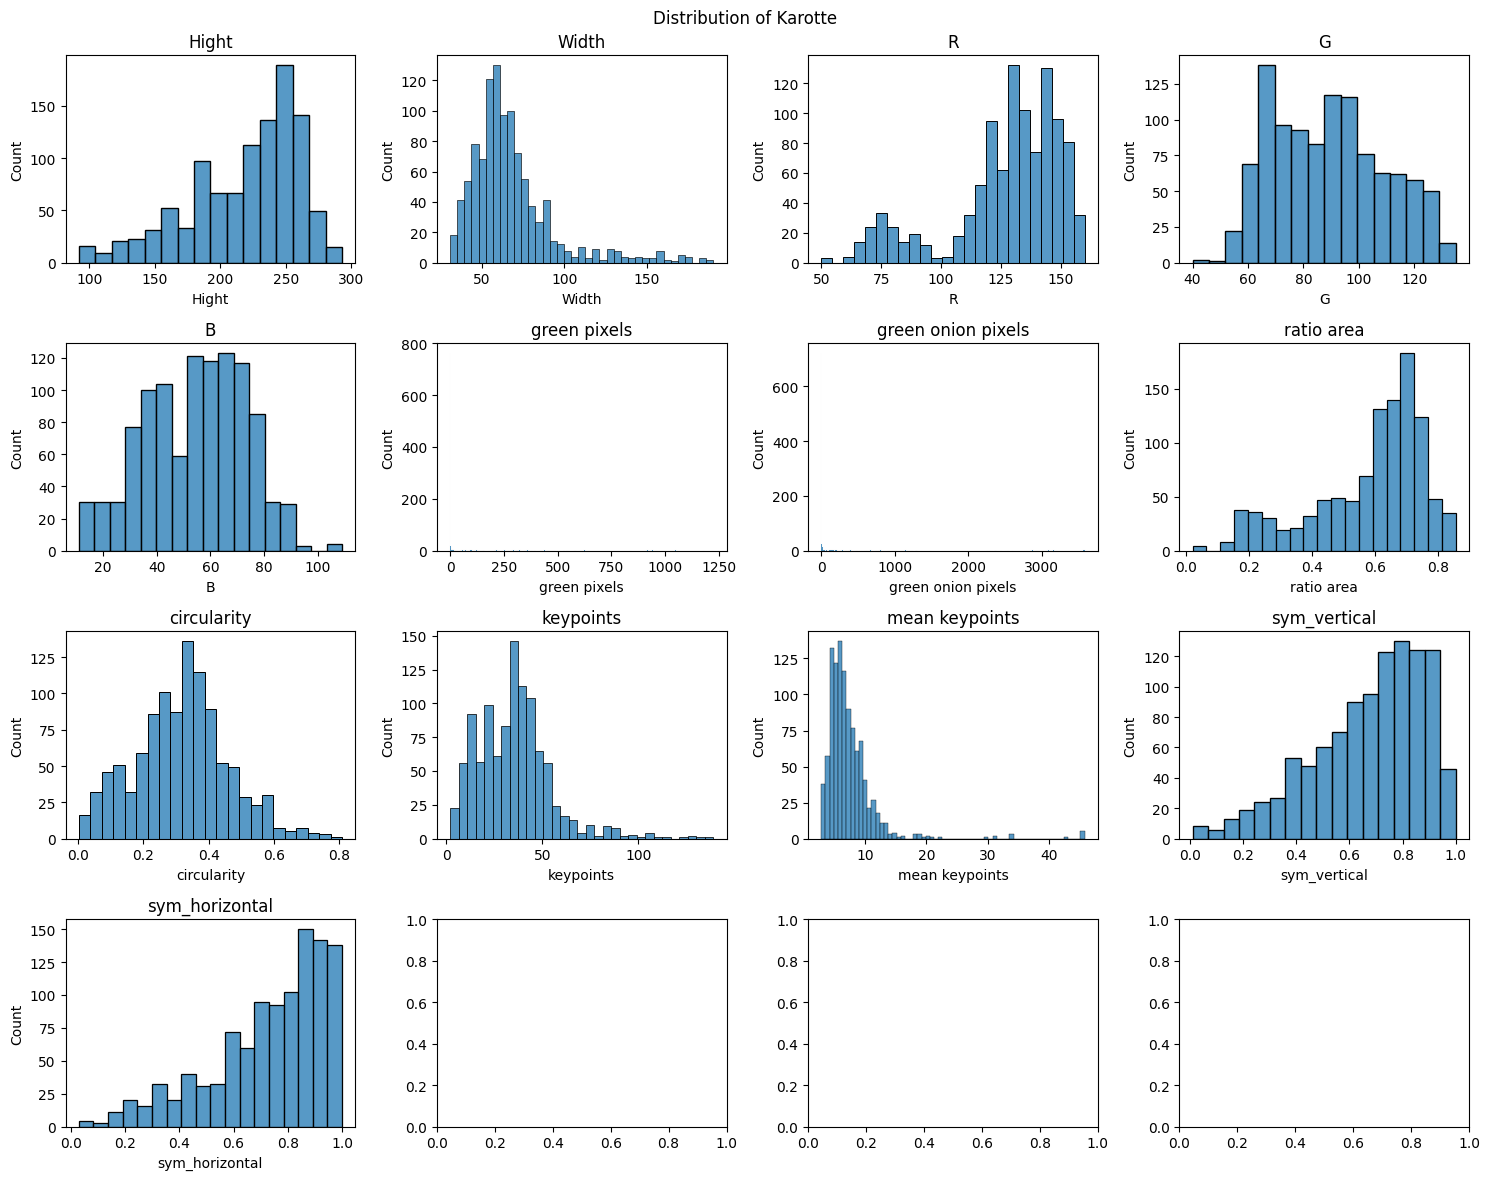

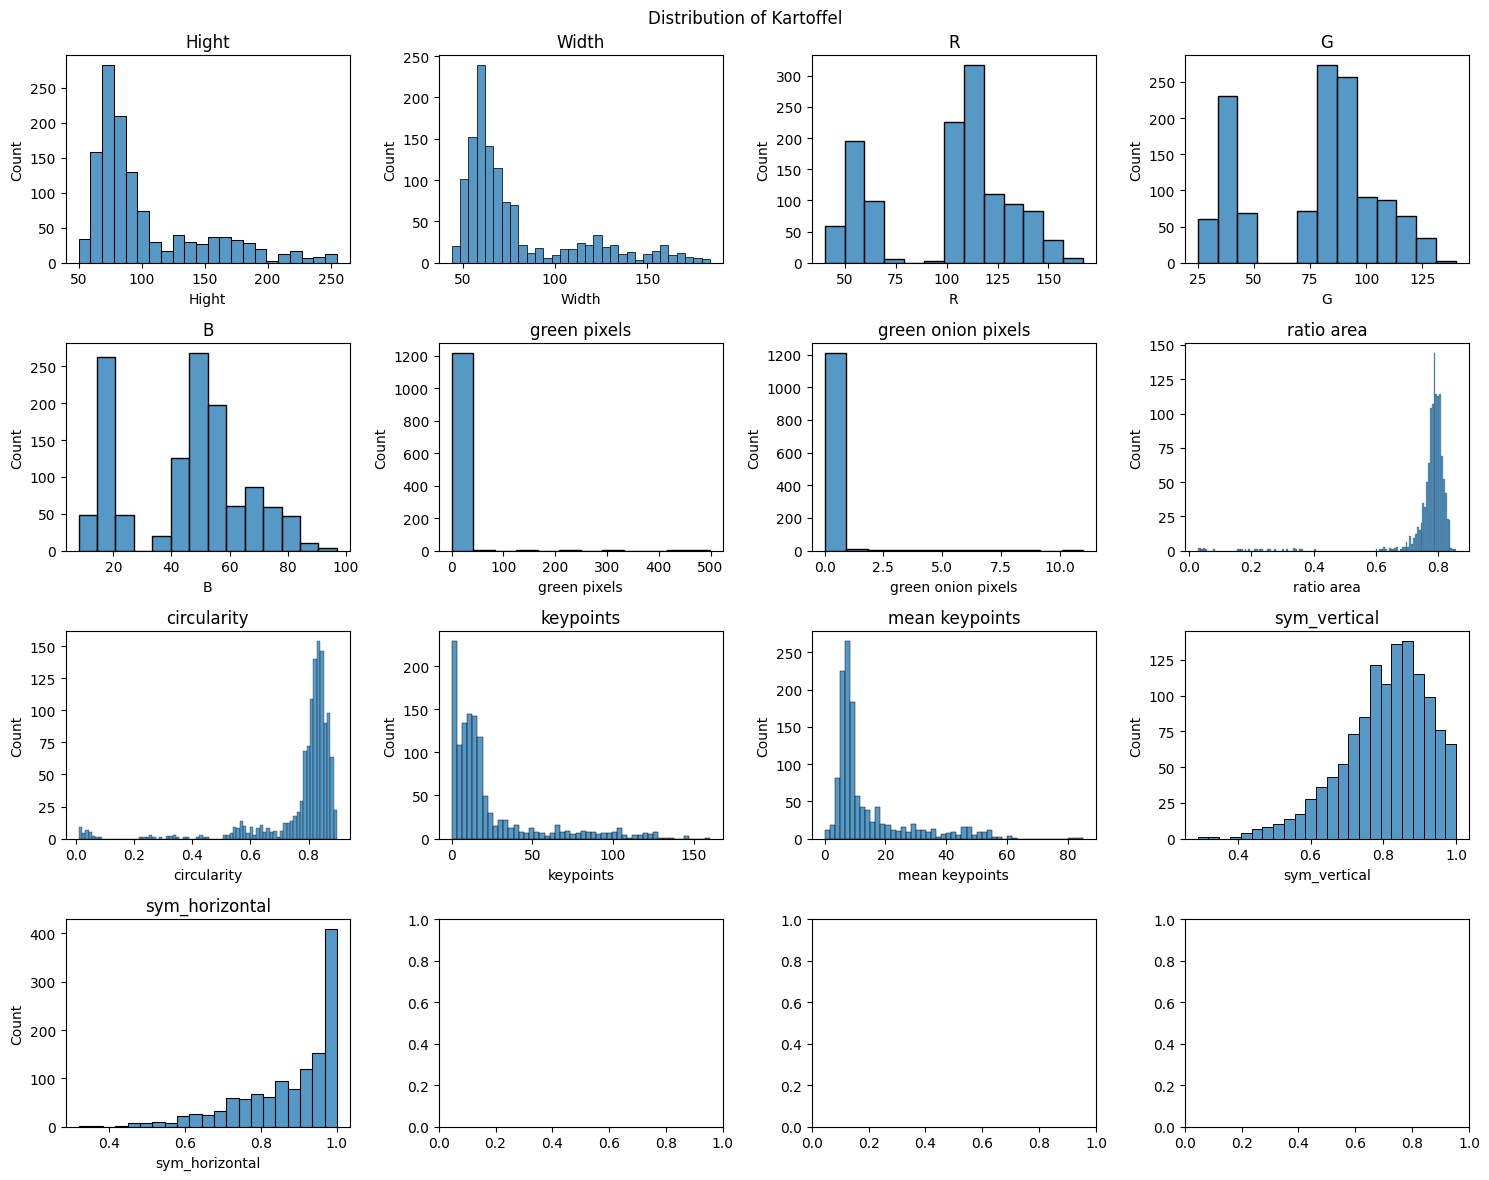

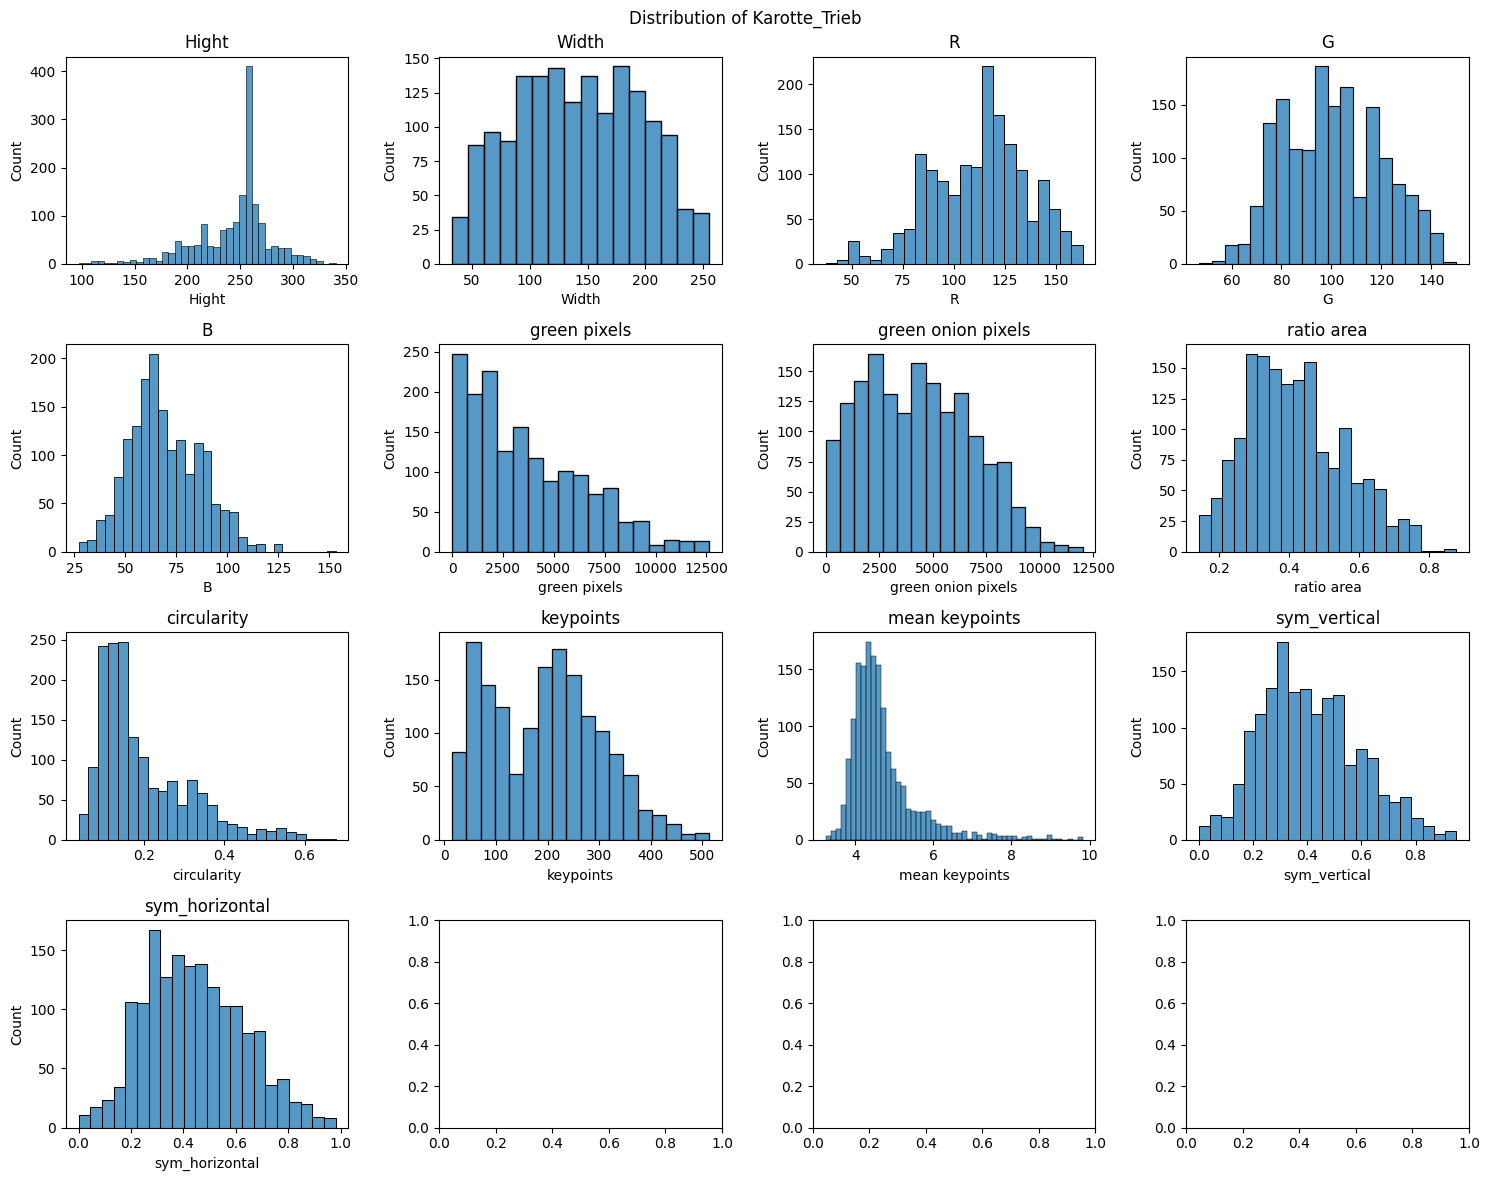

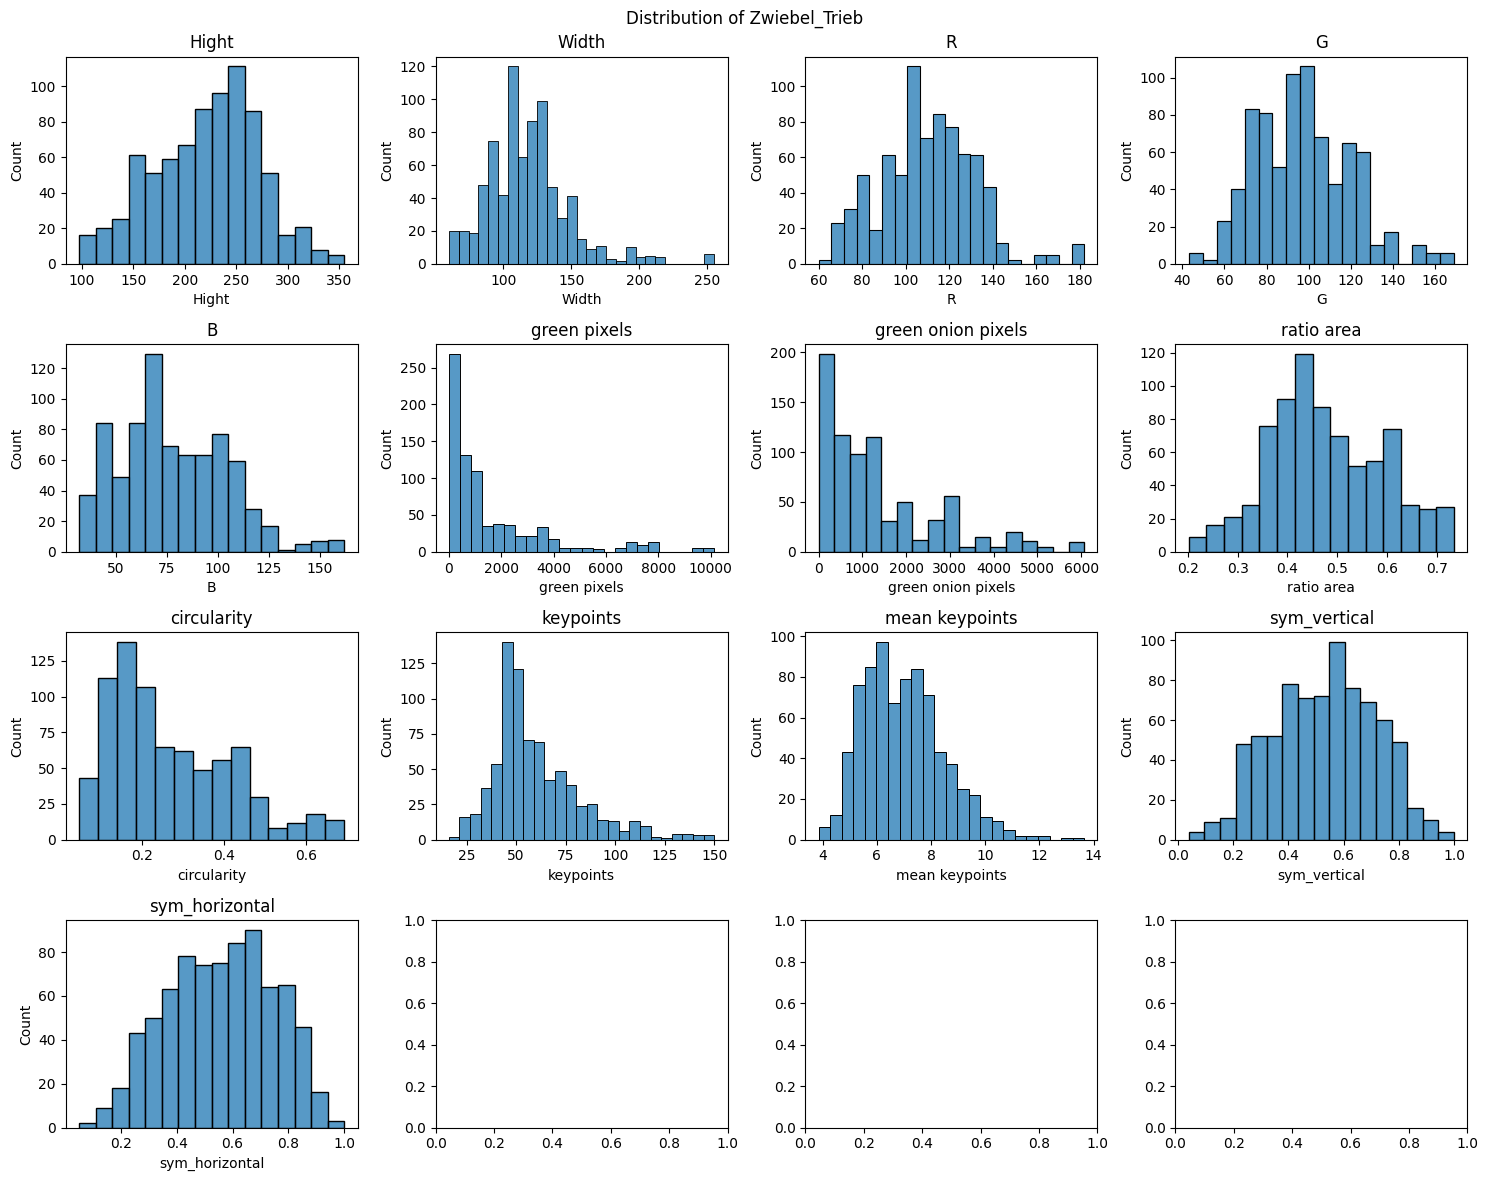

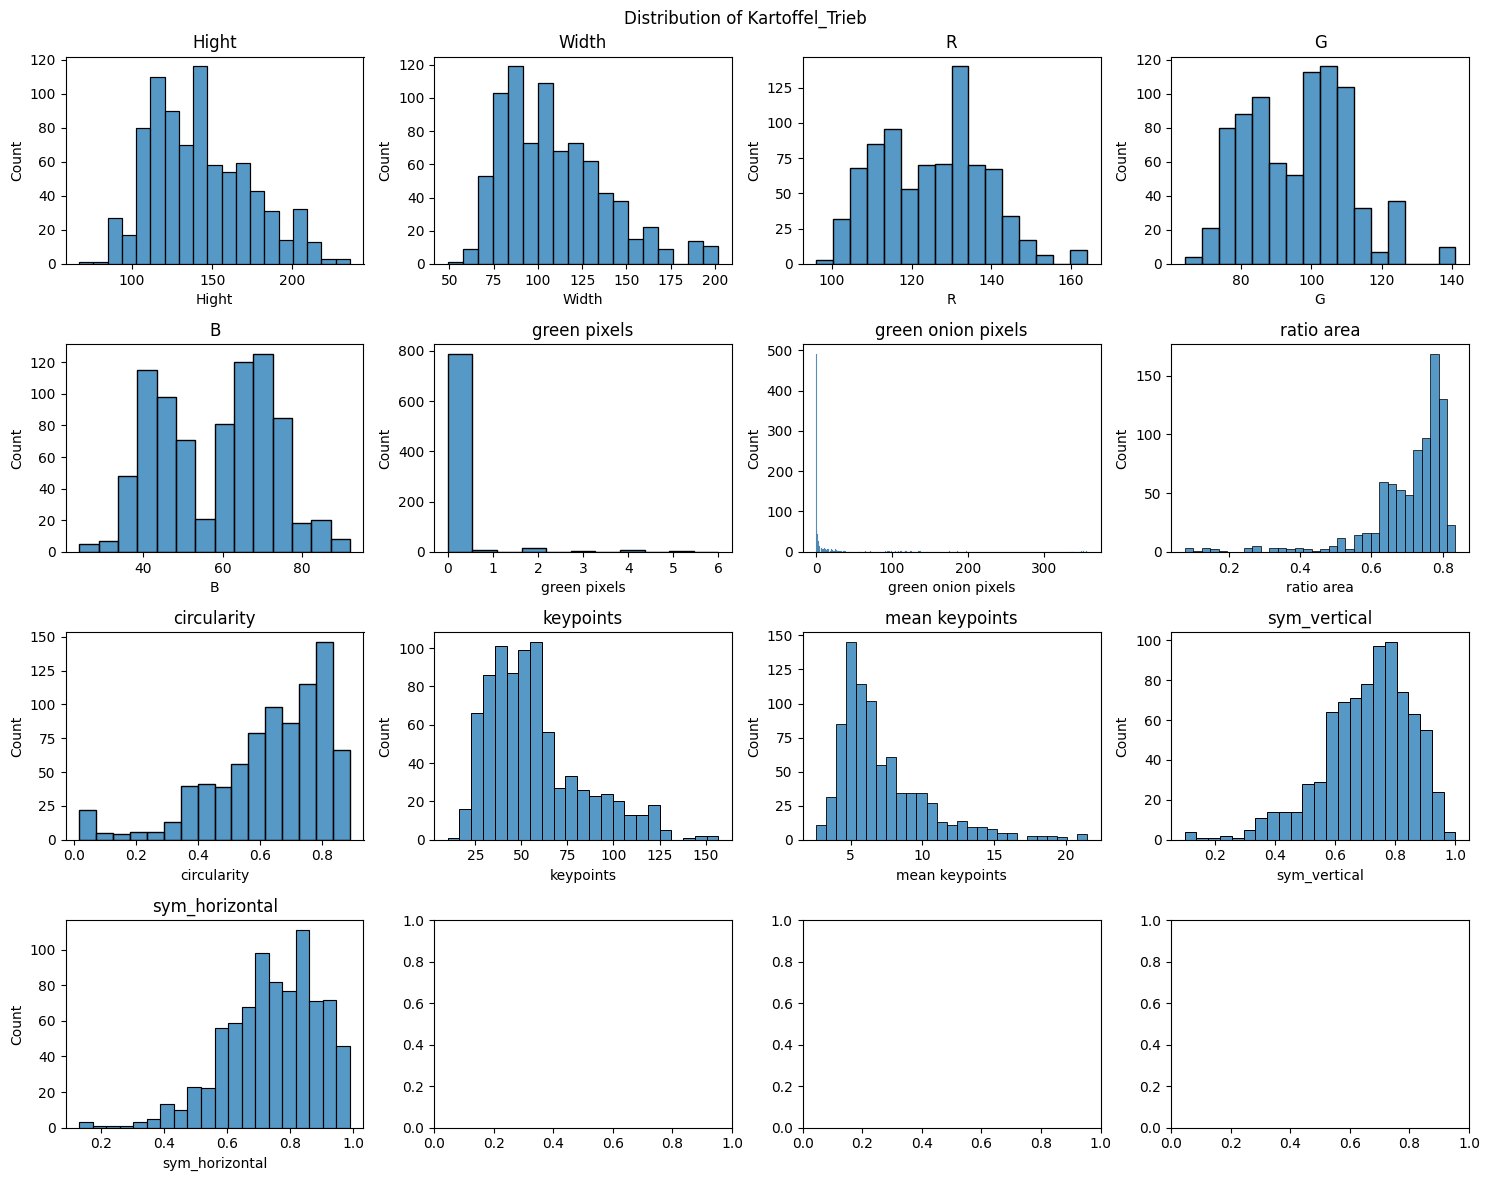

In [49]:
vegis_df_copy = vegis_df_copy.drop(columns=["Image"])
classes = vegis_df_copy["Label"].unique()
print(classes)
for cls in classes:
    v_df =  vegis_df_copy.loc[vegis_df_copy["Label"] == cls]
    v_df = v_df.drop(columns=["Label"])
    print("")

    cols = v_df.columns
    fig, axes = plt.subplots(4, 4, figsize=(15, 12))
    plt.suptitle(f"Distribution of {cls}")
    axes = axes.flatten()
    for i, col in enumerate(cols):
        sns.histplot(v_df[col], ax=axes[i], kde=False)
        axes[i].set_title(col)

    #fig.delaxes(axes[11])
    plt.tight_layout()
    plt.show()
    print("\n\n")